In [1]:
import os
import random

import pandas as pd
import numpy as np

import colorsys
import cv2
import albumentations as A
from tqdm.auto import tqdm

import torch

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch.optim as optim

In [2]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [3]:
def decode_rle_mask(rle_mask, shape=(520, 704)):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask (str): Run-length encoded segmentation mask string
    shape (tuple): Height and width of the mask

    Returns
    -------
    mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    mask = np.uint8(mask)
    return mask


def encode_rle_mask(mask, shape=(520, 704)):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()

In [4]:
def get_targets_mask(df, img_id):
    targets = df[df['id'] == img_id]['cell_type'].apply(lambda x: cls_map[x]).values
    rles = df[df['id'] == img_id]['annotation'].values
    return targets, rles

In [5]:
train_df = pd.read_csv('data/train.csv')

In [44]:
train_df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
id                   73585 non-null object
annotation           73585 non-null object
width                73585 non-null int64
height               73585 non-null int64
cell_type            73585 non-null object
plate_time           73585 non-null object
sample_date          73585 non-null object
sample_id            73585 non-null object
elapsed_timedelta    73585 non-null object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [46]:
train_df.id.nunique()

606

In [47]:
train_df.width.nunique()

1

In [48]:
train_df.height.nunique()

1

In [79]:
704*520

366080

In [49]:
train_df.cell_type.nunique()

3

In [50]:
train_df.cell_type.value_counts()

shsy5y    52286
cort      10777
astro     10522
Name: cell_type, dtype: int64

In [51]:
train_df.plate_time.nunique()

8

In [52]:
train_df.plate_time.value_counts()

11h30m00s    52286
09h00m00s     6462
13h30m00s     5704
13h00m00s     4060
19h30m00s     2130
11h59m00s     1292
07h30m00s      923
01h30m00s      728
Name: plate_time, dtype: int64

In [53]:
train_df.sample_date.nunique()

18

In [54]:
train_df.sample_date.value_counts()

2019-06-16    18435
2019-06-14    17026
2019-06-15    16825
2020-09-14     3406
2020-09-13     2572
2020-11-04     2213
2020-11-05     1996
2020-11-03     1976
2020-09-16     1756
2020-09-12     1429
2020-09-15     1359
2020-11-01     1222
2020-11-07      659
2020-10-26      651
2020-10-30      647
2020-10-29      592
2020-10-27      561
2020-11-06      260
Name: sample_date, dtype: int64

In [55]:
train_df.sample_id.nunique()

403

In [56]:
train_df.elapsed_timedelta.nunique()

8

In [57]:
train_df.elapsed_timedelta.value_counts()

0 days 11:30:00    52286
0 days 09:00:00     6462
0 days 13:30:00     5704
0 days 13:00:00     4060
0 days 19:30:00     2130
0 days 11:59:00     1292
0 days 07:30:00      923
0 days 01:30:00      728
Name: elapsed_timedelta, dtype: int64

In [58]:
train_df.annotation.nunique()

73470

In [59]:
len(train_df) - 73470

115

In [61]:
train_df[train_df.duplicated()]

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
13172,309be9da24d7,217210 1 217914 3 218617 6 219321 8 220025 10 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D7-3_Vessel-714_Ph_4,0 days 11:30:00
13173,309be9da24d7,180309 1 181012 4 181714 7 182417 9 183121 10 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D7-3_Vessel-714_Ph_4,0 days 11:30:00
13174,309be9da24d7,70528 2 71232 4 71936 7 72641 13 73346 13 7405...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D7-3_Vessel-714_Ph_4,0 days 11:30:00
13175,309be9da24d7,180309 1 181012 4 181714 7 182417 9 183121 10 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D7-3_Vessel-714_Ph_4,0 days 11:30:00
13195,309be9da24d7,65 15 769 15 1473 14 2177 14 2881 13 3585 13 4...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D7-3_Vessel-714_Ph_4,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
71782,f653c5eec0f8,303908 1 304611 3 305314 4 306017 6 306720 7 3...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D1-3_Vessel-714_Ph_1,0 days 11:30:00
71800,f653c5eec0f8,274327 4 275030 5 275732 8 276431 13 277132 16...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D1-3_Vessel-714_Ph_1,0 days 11:30:00
71806,f653c5eec0f8,265876 4 266581 4 267287 3 267992 4 268697 4 2...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D1-3_Vessel-714_Ph_1,0 days 11:30:00
71811,f653c5eec0f8,277852 1 278555 4 279257 7 279958 10 280660 11...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D1-3_Vessel-714_Ph_1,0 days 11:30:00


In [62]:
train_df_dupl = train_df[train_df.duplicated()]

In [63]:
train_df_dupl.id.unique()

array(['309be9da24d7', 'a7b1db2a42fc', 'a9fc5e872671', 'b5afaf901478',
       'bcf94f6bc975', 'ca5df17f6717', 'd8353ec73bdf', 'db5260527117',
       'de504eaa5349', 'f653c5eec0f8'], dtype=object)

In [64]:
train_df_dupl.cell_type.unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

удалим дупликаты из датасета

In [6]:
train_df.drop_duplicates(inplace=True)

In [7]:
cls_map = {value:idx for idx, value in enumerate(train_df['cell_type'].unique())}
cls_map_reversed = {cls_map[key]: key for key in cls_map.keys()}

In [67]:
cls_map

{'shsy5y': 0, 'astro': 1, 'cort': 2}

In [68]:
cls_map_reversed

{0: 'shsy5y', 1: 'astro', 2: 'cort'}

In [152]:
train_df.groupby('id').cell_type.nunique().sort_values(ascending=True)

id
0030fd0e6378    1
a97d5689d4c2    1
a9cf3efd023a    1
a9fc5e872671    1
aa2e2c09a57b    1
               ..
52f65c9194c0    1
539f24ebc61d    1
541ab846bcb0    1
549d34aaf226    1
ffdb3cc02eef    1
Name: cell_type, Length: 606, dtype: int64

In [11]:
img_id = train_df.iloc[0]['id']
img = cv2.imread(f'data/train/{img_id}.png')

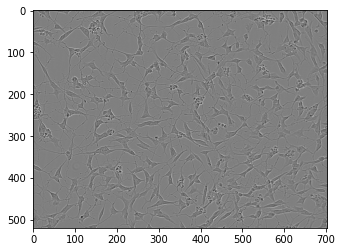

In [12]:
plt.imshow(img)

In [13]:
labels, rles = get_targets_mask(train_df, img_id)

In [14]:
len(rles)

395

In [15]:
mask = decode_rle_mask(rles[0])

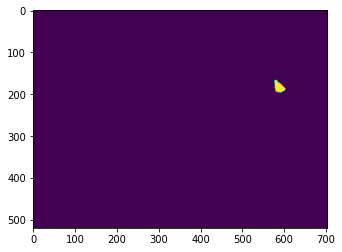

In [16]:
plt.imshow(mask)

In [17]:
mask = decode_rle_mask(str(encode_rle_mask(mask)).replace('[', '').replace(']', '').replace(',', ''))

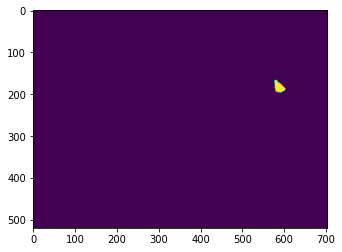

In [18]:
plt.imshow(mask)

In [19]:
masks = []
for mask in train_df.loc[train_df['id'] == img_id, 'annotation'].values:
    decoded_mask = decode_rle_mask(rle_mask=mask)
    masks.append(decoded_mask)

In [25]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [29]:
def plot_image_annotations(image, masks, aug=None):
    image = image.copy()
    
    colors = {unique_lbl:random_colors(1, True)[0] for unique_lbl in np.unique(labels)}
    
    if aug is not None:
        augmented = aug(image=image, masks=masks)
        image = augmented['image']
        masks = augmented['masks']
        #bboxes = augmented['bboxes']
    
#     bboxes = np.stack(bboxes).astype(int)
        
#     for idx, box in enumerate(bboxes):
#         color = tuple([int(value*255) for value in colors[labels[idx]]])
#         image = cv2.rectangle(image, (box[2], box[3]), (box[0], box[1]), color=color, thickness=2)
    
    for idx, mask in enumerate(masks):
        color = colors[labels[idx]]
        image = apply_mask(image, mask, color)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()

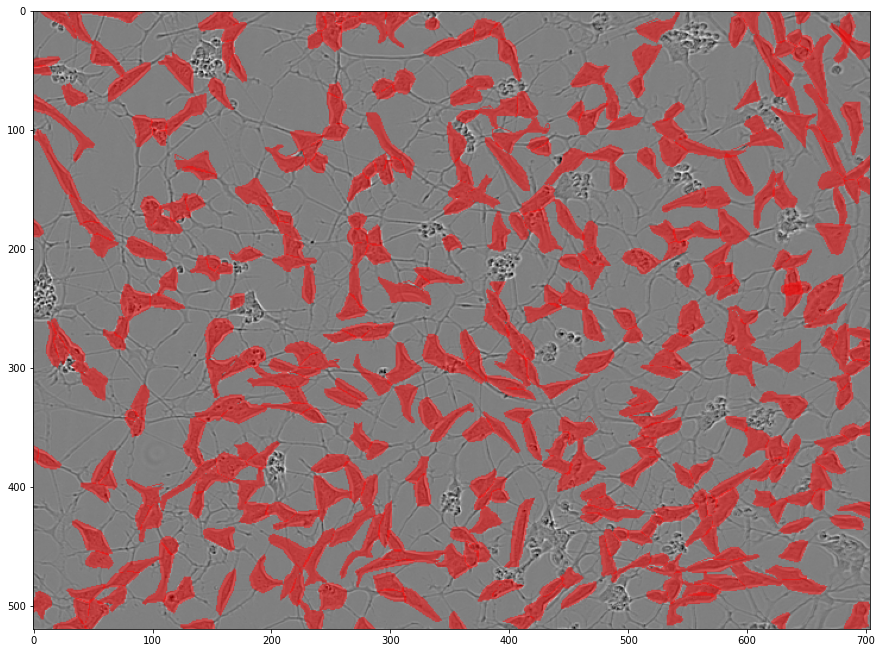

In [26]:
plot_image_annotations(image=img, masks=masks)

In [31]:
train_augmentations = A.Compose([
    A.RandomResizedCrop(640, 640, scale=(0.8, 1.0), ratio=(0.9, 1.3)),
    A.HorizontalFlip(),
    A.RandomRotate90()
])

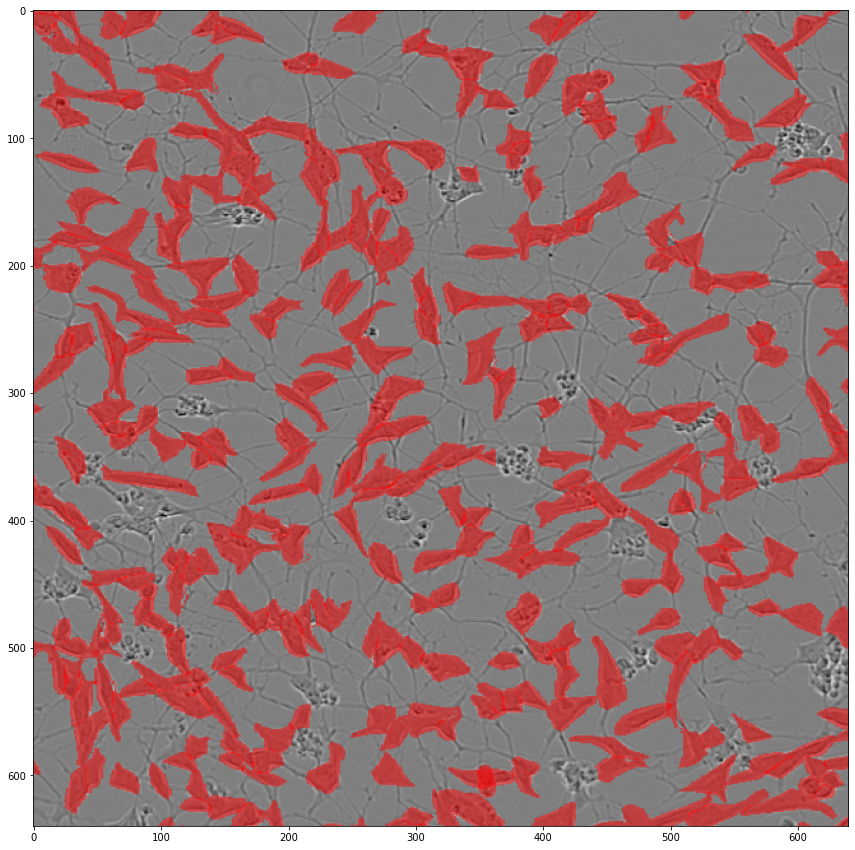

In [32]:
plot_image_annotations(image=img, masks=masks, aug=train_augmentations)

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [54]:
#!g1.1
model_unet = smp.Unet(activation='sigmoid')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [55]:
#!g1.1
class Unet_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, df, split='train', aug=None):
        self.augmentations = aug
        
        train, test = train_test_split(df['id'].unique(), train_size=0.9, random_state=42)
        if split=='train':
            self.dataset = train
        else:
            self.dataset = test
            
        self.dict_df = {img_id:df[df['id']==img_id] for img_id in tqdm(self.dataset)}
        self.root = root
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img_id = self.dataset[index]
        image = cv2.imread(os.path.join(self.root, img_id+'.png'))
        
        info = self.dict_df[img_id]
        n_objects = len(info['annotation'])
                
        labels, rles = get_targets_mask(info, img_id)
        
        masks = np.zeros((520, 704))
        for mask in rles:
            decoded_mask = decode_rle_mask(rle_mask=mask)
            masks += decoded_mask
            
        if self.augmentations is not None:
            augmented = self.augmentations(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
            
        
       

        
        return image, masks

In [67]:
#!g1.1
train_transform = A.Compose(
    [
        A.Resize(512, 704),
#         A.LongestMaxSize(512),
#         A.PadIfNeeded(min_height=512, min_width=512),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ]
    )
val_transform = A.Compose(
    [
        A.Resize(512, 704),
#         A.LongestMaxSize(512),
#         A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2(),
    ]
    )

In [68]:
#!g1.1
train_dataset = Unet_Dataset('data/train/', train_df, 'train', train_transform)
valid_dataset = Unet_Dataset('data/train/', train_df, 'test', val_transform)

  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

отрисуем картинку из датасета

In [69]:
#!g1.1
img, mask = train_dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


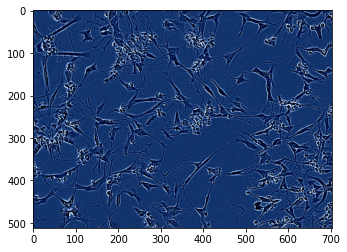

In [70]:
#!g1.1
plt.imshow(img.permute(1, 2, 0))

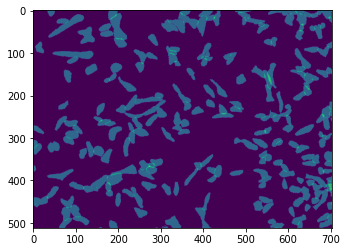

In [71]:
#!g1.1
plt.imshow(mask)

In [72]:
#!g1.1
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=False)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=4, shuffle=False)

In [59]:
#!g1.1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_unet.to(device);

In [60]:
device

device(type='cuda')

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_unet.parameters(), lr=0.001, momentum=0.9)

In [61]:
#!g1.1
criterion = nn.BCELoss()
optimizer = optim.SGD(model_unet.parameters(), lr=0.001, momentum=0.9)

In [62]:
#!g1.1
model_unet.train();

In [74]:
#!g1.1
epochs = 20
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        images, masks = data
        images, masks = images.cuda(), masks.cuda()
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_unet(images)
        
        
        loss = criterion(outputs, masks.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss / 32
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

print('Finished Training')

Epoch: 0 - Train Loss 0.1569
Epoch: 1 - Train Loss 0.1482
Epoch: 2 - Train Loss 0.1425
Epoch: 3 - Train Loss 0.1386
Epoch: 4 - Train Loss 0.1337
Epoch: 5 - Train Loss 0.1312
Epoch: 6 - Train Loss 0.1289
Epoch: 7 - Train Loss 0.1253
Epoch: 8 - Train Loss 0.1237
Epoch: 9 - Train Loss 0.1221
Epoch: 10 - Train Loss 0.1199
Epoch: 11 - Train Loss 0.1186
Epoch: 12 - Train Loss 0.1175
Epoch: 13 - Train Loss 0.1161
Epoch: 14 - Train Loss 0.1147
Epoch: 15 - Train Loss 0.1135
Epoch: 16 - Train Loss 0.1120
Epoch: 17 - Train Loss 0.1114
Epoch: 18 - Train Loss 0.1112
Epoch: 19 - Train Loss 0.1099
Finished Training


In [76]:
#!g1.1
torch.save(model_unet.state_dict(), 'unet_param.pkl')
torch.save(model_unet, 'unet.pkl')

In [244]:
#!g1.1
model_unet.eval();
iou_sum = 0
iou = 0
intersection = 0
union = 0
iou_s = 0
list_pred = []
list_targ = []
with torch.no_grad():
    for image, mask in valid_loader:
        output = model_unet(image.to('cuda'))
        iou_s = 0
        for i in range(output.shape[0]):
            
            output = output.cpu()
            out = np.where(output[i][0][:,:]<0.4, 0, 1)
            msk = mask[i][:,:].cpu().numpy()
            intersection = np.logical_and(out, msk)
            union = np.logical_or(out,msk)
            iou = intersection.sum()/union.sum()
            
            iou_s += iou
        iou_sum += iou_s/output.shape[0]
        
        
iou_res = iou_sum/len(valid_loader)

In [245]:
#!g1.1
iou_res

0.32284898557011593

маловато получилось)

In [ ]:
#!g1.1


In [113]:
#!g1.1
image, mask = next(iter(valid_loader))

In [114]:
#!g1.1
image.shape

torch.Size([4, 3, 512, 704])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


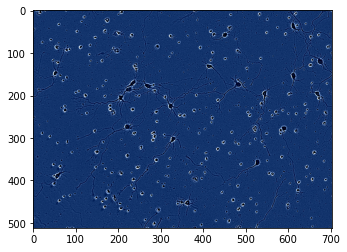

In [116]:
#!g1.1
plt.imshow(image[0].permute(1, 2, 0))

In [117]:
#!g1.1
mask.shape

torch.Size([4, 512, 704])

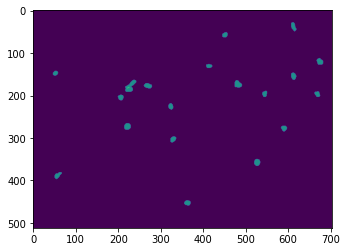

In [118]:
#!g1.1
plt.imshow(mask[0])

In [297]:
#!g1.1
output = model_unet(image.cuda())

In [121]:
#!g1.1
output.shape

torch.Size([4, 1, 512, 704])

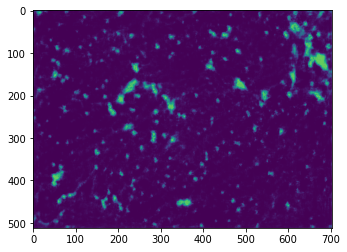

In [125]:
#!g1.1
plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())

In [149]:
#!g1.1
out_mask = output[0][0].cpu().detach().numpy()

In [150]:
#!g1.1
tr = A.Compose([A.Resize(520, 704)],)
aug = tr(image=out_mask)
out_mask = aug['image']

In [202]:
#!g1.1
out_mask.max()

0.5680637

In [203]:
#!g1.1
out_mask.min()

4.070661e-07

In [ ]:
#!g1.1


пришлось использовать кастомный порог для преда

In [210]:
#!g1.1
out_mask_norm = np.where(out_mask<0.4, 0, 1)

In [ ]:
#!g1.1


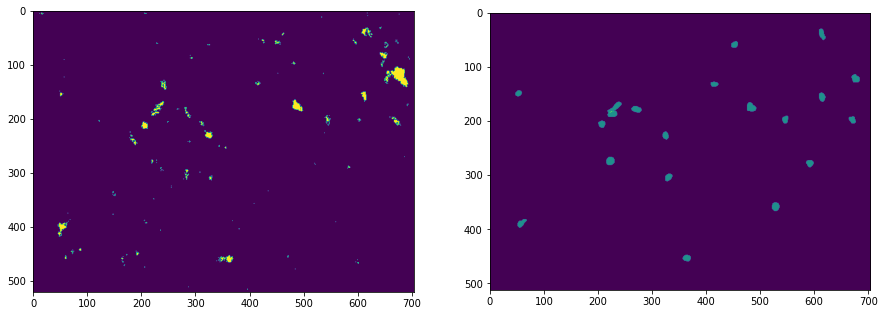

In [411]:
#!g1.1
plt.figure(1, figsize=(15, 15))
plt.subplot(121)
plt.imshow(out_mask_norm)
plt.subplot(122)
plt.imshow(mask[0])

In [214]:
#!g1.1
str(encode_rle_mask(out_mask_norm, shape=(520, 704))).replace('[', '').replace(']', '').replace(',', '')

'3536 2 3727 1 4138 1 4237 1 4240 3 4244 1 4431 4 4945 2 5605 1 7659 1 8982 1 9686 1 22468 1 23146 1 23169 3 23847 1 23849 2 23874 2 24551 6 24578 1 25250 7 25259 2 25954 7 25963 2 26658 7 26667 3 27362 6 27371 6 28065 8 28075 6 28769 6 28779 3 28783 1 29472 7 29483 4 30031 2 30176 6 30188 1 30190 1 30734 3 30882 5 30892 1 30894 1 30897 2 31437 2 31588 3 31596 3 31601 3 32141 3 32293 2 32302 2 32306 2 32845 1 32997 4 33006 2 33704 1 33710 1 34416 2 35120 3 37729 1 37905 1 38440 2 39144 4 39312 2 39391 1 39393 1 39848 4 39873 1 39875 1 40016 3 40096 1 40576 4 40584 1 40723 1 41259 1 41280 3 41285 3 41427 3 41502 1 41504 2 41963 2 41985 2 41988 6 42131 4 42187 3 42211 1 42469 1 42666 2 42689 6 42697 1 42835 4 42891 1 42893 2 42914 2 43173 3 43392 7 43540 1 43542 1 43595 1 43597 1 43619 1 44097 1 44105 1 44245 2 44303 2 44675 2 44678 2 44809 1 45003 1 45008 1 45380 1 45383 1 45713 1 46415 2 47118 3 47818 1 47821 2 48523 1 48525 2 49227 2 55554 2 55558 1 55563 3 56258 6 56267 1 56962 10 56

In [ ]:
#!g1.1


тест и сабмит

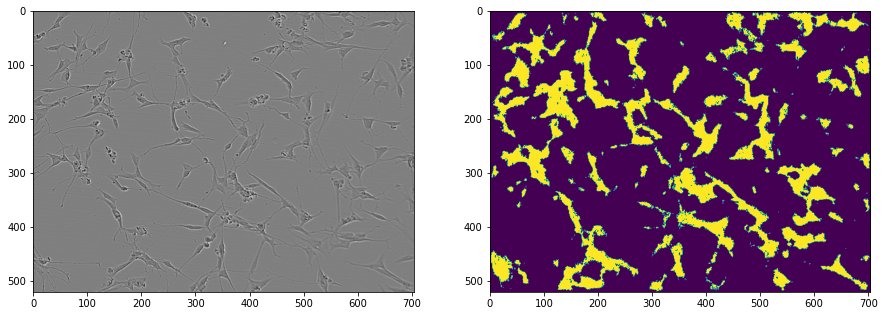

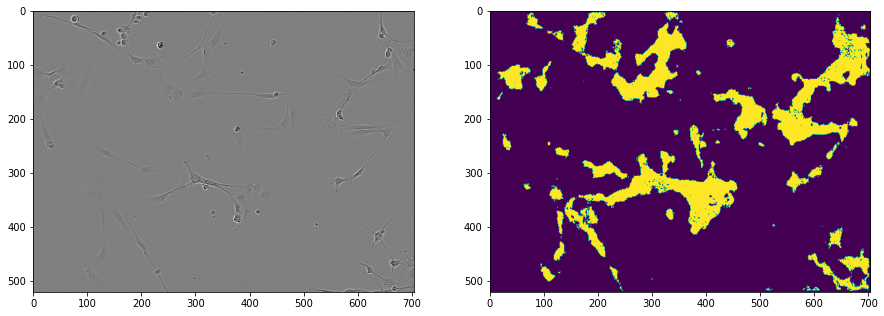

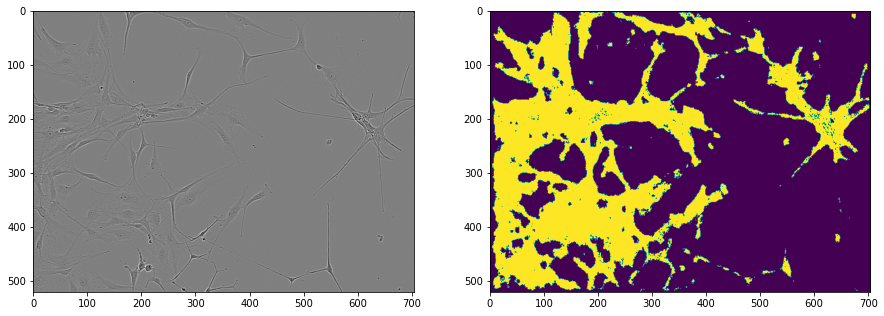

In [408]:
#!g1.1
tr_in = A.Compose([A.Resize(512, 704),A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),])
tr_out = A.Compose([A.Resize(520, 704)],)
i = 1
submit = pd.DataFrame()
submit['id'] = 0
submit['predicted'] = 0

list_file = os.listdir('data/test/')
list_file.sort()
for file_name in list_file:
    
    test_image = cv2.imread('data/test/' + file_name)
    
    aug_in = tr_in(image=test_image)
    test_image1 = aug_in['image']
    
    test_out = model_unet(test_image1.view(1, 3, 512, 704).float().cuda())
    test_out = test_out.squeeze(0)
    test_out = test_out.permute(1, 2, 0)#((512, 704, 1))
    aug_out = tr_out(image=test_out.cpu().detach().numpy().astype(float))
    out_mask = aug_out['image']
    out_mask = np.where(out_mask<0.4, 0, 1)
    
    plt.figure(i, figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(test_image)
    plt.subplot(122)
    plt.imshow(out_mask)
    
    mask_enc = str(encode_rle_mask(out_mask.reshape((520, 704)), shape=(520, 704))).replace('[', '').replace(']', '').replace(',', '')
    submit.loc[i, 'id'] = file_name[:-4]
    submit.loc[i, 'predicted'] = mask_enc
    
    i += 1
    

In [409]:
#!g1.1
submit

,id,predicted
1,7ae19de7bc2a,1974 2 2310 1 2561 1 2675 1 2679 2 2694 1 3010...
2,d48ec7815252,1604 3 1614 2 1740 5 2304 2 2307 1 2310 1 2314...
3,d8bfd1dafdc4,1577 1 1579 1 2281 4 2289 4 2294 2 2301 1 2314...


In [410]:
#!g1.1
submit.to_csv('submission.csv', index=False)